# MLP Classifier using Bluetooth data

<p>Jupyter Notebook which aims to explore the ML algorithm Multi-Layer Perceptron as a Classifier algorithm using BLE technology moreover using the strength of the signal as a basis. </p>

## Imports
Imports of the libraries to be used throughout the experiments

In [1]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import scipy

#Warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#Graphical Display
%matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

## Load File and Structure Data Function
Function to load csv and structure data accordingly

In [2]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

## Initialize Training Data

In [3]:
def find_beacon_index():
    first_beacon_index = -1
    for ap in dataset.iloc[:,4:]:
        if ap.islower() == False:
            first_beacon_index = list(dataset).index(ap)
            break
    return first_beacon_index

In [4]:
dataset = load_file('radiomapBluetoothWiFiclassifier.csv')
beacon_index = find_beacon_index()
X_train = dataset.iloc[:,beacon_index:]
Y_train = dataset.iloc[:,3:4]
nan_filler = X_train.min().min()*1.010
X_train = X_train.replace(0, np.nan)
X_train = X_train.fillna(nan_filler)
display(X_train.shape)
display(Y_train.shape)
display(dataset.describe().transpose())
n_features = X_train.shape[1]
display(n_features)

(120, 2)

(120, 1)

count       mean        std   min    25%   50%    75%  \
Fingerprint ID     120.0  64.250000  36.047646   4.0  33.75  63.5  93.25   
coordinate_X       120.0   0.000000   0.000000   0.0   0.00   0.0   0.00   
coordinate_Y       120.0   0.000000   0.000000   0.0   0.00   0.0   0.00   
c4:e9:84:42:ac:ff  120.0 -67.833333  11.998833 -81.0 -73.00 -69.0 -65.00   
00:26:5b:d1:93:38  120.0 -14.916667  30.767107 -80.0   0.00   0.0   0.00   
00:06:91:d4:77:02  120.0 -58.416667  20.832499 -78.0 -70.00 -62.0 -56.00   
00:26:5b:d1:93:39  120.0 -15.000000  30.936639 -80.0   0.00   0.0   0.00   
8c:5b:f0:78:a1:d6  120.0 -63.508333  11.451759 -79.0 -67.00 -65.0 -63.00   
00:06:91:d4:77:00  120.0 -57.066667  21.986525 -78.0 -69.00 -61.0 -56.00   
0c:47:3d:13:88:e8  120.0  -7.200000  21.755169 -80.0   0.00   0.0   0.00   
0c:47:3d:13:88:e9  120.0  -8.025000  23.172884 -80.0   0.00   0.0   0.00   
68:b6:fc:5b:01:08  120.0  -1.333333  10.284469 -80.0   0.00   0.0   0.00   
1c:ab:c0:df:99:c8  120.0 -33.941667  36.558528 -80.0 -71.00   0.0   0.00   
1c:ab:c0:df:99:c9  120.0 -27.875000  35.582916 -79.0 -70.00   0.0   0.00   
bc:4d:fb:52:ea:28  120.0  -7.750000  23.351264 -79.0   0.00   0.0   0.00   
bc:4d:fb:52:ea:29  120.0  -7.825000  23.578106 -80.0   0.00   0.0   0.00   
00:fc:8d:cf:98:08  120.0  -1.316667  10.155913 -79.0   0.00   0.0   0.00   
00:fc:8d:cf:98:09  120.0  -1.300000  10.027358 -78.0   0.00   0.0   0.00   
FF:20:88:3C:97:E7  120.0 -81.875000  15.037523 -98.0 -91.00 -82.0 -76.75   
CA:E0:7D:11:26:B3  120.0 -79.791667  10.749161 -99.0 -85.25 -79.0 -76.00   

                     max  
Fingerprint ID     132.0  
coordinate_X         0.0  
coordinate_Y         0.0  
c4:e9:84:42:ac:ff    0.0  
00:26:5b:d1:93:38    0.0  
00:06:91:d4:77:02    0.0  
00:26:5b:d1:93:39    0.0  
8c:5b:f0:78:a1:d6    0.0  
00:06:91:d4:77:00    0.0  
0c:47:3d:13:88:e8    0.0  
0c:47:3d:13:88:e9    0.0  
68:b6:fc:5b:01:08    0.0  
1c:ab:c0:df:99:c8    0.0  
1c:ab:c0:df:99:c9    0.0  
bc:4d:fb:52:ea:28    0.0  
bc:4d:fb:52:ea:29    0.0  
00:fc:8d:cf:98:08    0.0  
00:fc:8d:cf:98:09    0.0  
FF:20:88:3C:97:E7    0.0  
CA:E0:7D:11:26:B3    0.0

2

## Beacons Graphical Display
Graphical display with the average strength signal transmitted by each beacon

<BarContainer object of 2 artists>

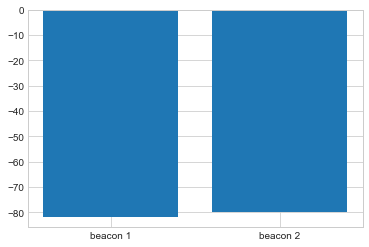

In [5]:
count_beacons = {}
counter = 1
beacons = X_train
for beacon in beacons:
    mean_value = dataset[beacon].mean()
    count_beacons['beacon ' + str(counter)] = mean_value
    counter = counter + 1
plt.bar(range(len(count_beacons)),list(count_beacons.values()),align='center',tick_label=list(count_beacons.keys()))

## Number of Fingerprints per Reference Point Graphical Display
Graphical display of the number of fingerprints retrieved at each reference point

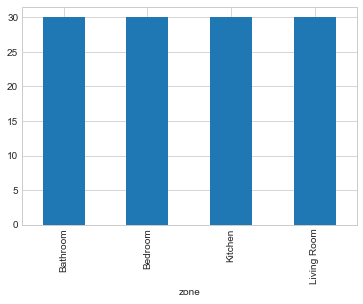

In [6]:
reference_points = dataset.groupby(['zone'])
reference_points.size().plot(kind="bar")

## Signal Strength Distribution Display
Graphical display of the distribution of the signal strength

### Bluetooth Signal Strength

Text(0, 0.5, 'Probability')

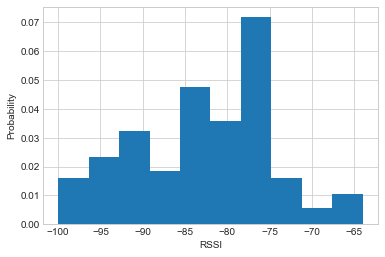

In [7]:
flatten_results = X_train.values.flatten().tolist()
plt.hist(flatten_results,density=True)
plt.xlabel('RSSI')
plt.ylabel('Probability')

## Initialize MLP Parameters arrays
Initialization of the arrays with the different possible values for the parameters of MLP Classifier function

In [8]:
#MLP Configurable Arrays
activation_function_list = ['logistic','tanh','relu'] 
solver_list = ['lbfgs','sgd','adam']
filters_list = ["Median","Mean","No Filter"]
learning_rate_list = ['constant','invscaling','adaptive']
alpha_list = [0.0001,0.001,1e-05,0.1]
number_iterations_list = [200,400,500,1000,2000]
scaler_list = [StandardScaler(),MinMaxScaler(),MaxAbsScaler(),None]
momentum_list = [0,0.9]
default_data_scenario = Y_train.copy()
default_data_scenario_groups = default_data_scenario["zone"].map(str)

## Statistics Output Format
Structure of the statistical output of each call to the MLP Classification Function

In [9]:
def structure_data(data,precision,accuracy,f1score):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    precision = precision
    accuracy = accuracy
    f1score = f1score
    statistical_results = [mae,mse,rsme,precision,accuracy,f1score]
    return statistical_results

## Configurable MLP Classifier Function 

In [10]:
def compute_MLP_with_Classification(number_features = n_features,flag = 1,trainX_data = None,trainY_data = None,testX_data = None,testY_data = None,scaler = StandardScaler(),
                                    cross_validation = None,activation_function='relu',solver_function='adam',
                                    learning_rate_value='constant',momentum_value = 0.9,alpha_value = 0.0001 ,max_iterations = 1000):
    # Init the NN Classifier
    mlp_classifier_estimator = MLPClassifier(hidden_layer_sizes=(number_features,number_features,number_features),
                                            activation=activation_function,solver=solver_function,max_iter=max_iterations,
                                            learning_rate=learning_rate_value,momentum=momentum_value,
                                             alpha=alpha_value,random_state=6
                                            )
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,mlp_classifier_estimator)
    else:
        main_estimator = mlp_classifier_estimator
    if cross_validation is None:
        # Fit the training data
        main_estimator.fit(trainX_data,trainY_data.values.ravel())
        # Predict the results of the testing data features
        predict_test = main_estimator.predict(testX_data)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    else:
        predict_test = cross_val_predict(main_estimator,testX_data.values,testY_data.values.ravel(),cv = cross_validation,groups=default_data_scenario_groups)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    # Structure data to statistics
    statistics = pd.DataFrame(report).transpose()
    statistical_array = list()
    coord_cols = ['zone']
    predictions = pd.DataFrame(predict_test,columns=coord_cols)
    result = testY_data.join(predictions, rsuffix="_predicted")
    error = pd.DataFrame(np.where(predictions[coord_cols] != result[coord_cols],1,0), columns=["error"])
    result = pd.concat([result,error], axis = 1)
    if flag == 0:
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(result)
    return structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean())

## Experiments

### 1st Experiment - Running MLP function with default parameters and testing data equal to training data

In [11]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
result = compute_MLP_with_Classification(flag=0,
                                         trainX_data=X_train,trainY_data=Y_train,
                                         testX_data=X_train,testY_data=Y_train,
                                         scaler=StandardScaler())
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

Confusion Matrix:
[[ 3 11  2 14]
 [ 0 28  2  0]
 [ 1  9 20  0]
 [ 1 14  1 14]]


precision    recall  f1-score     support
Bathroom       0.600000  0.100000  0.171429   30.000000
Bedroom        0.451613  0.933333  0.608696   30.000000
Kitchen        0.800000  0.666667  0.727273   30.000000
Living Room    0.500000  0.466667  0.482759   30.000000
accuracy       0.541667  0.541667  0.541667    0.541667
macro avg      0.587903  0.541667  0.497539  120.000000
weighted avg   0.587903  0.541667  0.497539  120.000000

zone zone_predicted  error
0     Kitchen        Bedroom      1
1     Kitchen        Bedroom      1
2     Kitchen        Bedroom      1
3     Kitchen        Bedroom      1
4     Kitchen        Bedroom      1
..        ...            ...    ...
115  Bathroom    Living Room      1
116  Bathroom        Bedroom      1
117  Bathroom        Bedroom      1
118  Bathroom    Living Room      1
119  Bathroom    Living Room      1

[120 rows x 3 columns]

mae       mse      rmse  precision  accuracy  f1-score
0  0.458333  0.458333  0.677003   0.581298  0.541667  0.503843

### 2nd Experiment - Tunning parameters with GridSearchCV

In [12]:
def tune_parameters():
    results = []
    tuned_parameters = {
        'mlp__activation':activation_function_list,
        'mlp__solver':solver_list,
        'mlp__alpha': alpha_list,
        'mlp__max_iter':number_iterations_list
    }
    sgd_parameters = {
        'mlp__learning_rate':learning_rate_list,
        'mlp__momentum':momentum_list,
        'mlp__alpha': alpha_list,
        'mlp__max_iter':number_iterations_list
    }
    scores = ['precision', 'recall','f1']
    for score in scores:
        pipe = Pipeline([('standardizer', StandardScaler()), ('mlp', MLPClassifier())])
        clf = GridSearchCV(
           pipe, tuned_parameters, scoring='%s_macro' % score,n_jobs=-1
        )
        clf.fit(X_train,Y_train.values.ravel())
        clf.best_params_['score'] = score
        results.append(clf.best_params_)
    gridcv_results = pd.DataFrame(results)
    display(gridcv_results)
    results=[]
    for score in scores:
        pipe = Pipeline([('standardizer', StandardScaler()), ('mlp', MLPClassifier())])
        clf = GridSearchCV(
           pipe, sgd_parameters, scoring='%s_macro' % score,n_jobs=-1
        )
        clf.fit(X_train,Y_train.values.ravel())
        clf.best_params_['score'] = score
        results.append(clf.best_params_)
    gridcv_results = pd.DataFrame(results)
    display(gridcv_results)

In [13]:
tune_parameters()

mlp__activation  mlp__alpha  mlp__max_iter mlp__solver      score
0            relu     0.00100           1000        adam  precision
1            relu     0.00100           1000        adam     recall
2            relu     0.00001           1000        adam         f1

mlp__alpha mlp__learning_rate  mlp__max_iter  mlp__momentum      score
0     0.00001           adaptive           1000            0.9  precision
1     0.00010           constant           1000            0.9     recall
2     0.00100         invscaling           1000            0.0         f1

### 3th Experiment - Running the MLP function with default parameters and Hold-out Cross Validation

mae       mse      rmse  precision  accuracy  f1-score  test_size
8  0.453704  0.453704  0.673575   0.477566  0.546296  0.487005        0.9
5  0.472222  0.472222  0.687184   0.457285  0.527778  0.468870        0.6
3  0.479167  0.479167  0.692219   0.443636  0.520833  0.461452        0.4
0  0.500000  0.500000  0.707107   0.484694  0.500000  0.429592        0.1
1  0.500000  0.500000  0.707107   0.446429  0.500000  0.439332        0.2
4  0.500000  0.500000  0.707107   0.434615  0.500000  0.441995        0.5
6  0.523810  0.523810  0.723747   0.431923  0.476190  0.433499        0.7
2  0.527778  0.527778  0.726483   0.420893  0.472222  0.419131        0.3
7  0.552083  0.552083  0.743023   0.446699  0.447917  0.427840        0.8

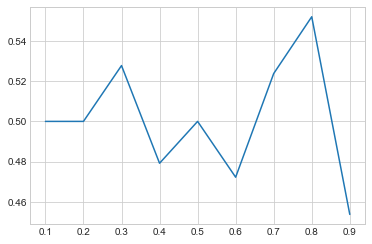

In [14]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
for size in test_sizes:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train,Y_train, test_size = size, random_state = 6,stratify=default_data_scenario_groups)
    X_train_split = X_train_split.reset_index(drop=True)
    X_test_split = X_test_split.reset_index(drop=True)
    y_train_split = y_train_split.reset_index(drop=True)
    y_test_split = y_test_split.reset_index(drop=True)
    result = compute_MLP_with_Classification(trainX_data=X_train_split,trainY_data=y_train_split,
                                             testX_data=X_test_split,testY_data=y_test_split,
                                             scaler=StandardScaler())
    result.append(size)
    results.append(result)
statistical_cols.append('test_size')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae'],))
plt.plot(statistics['test_size'],statistics['mae'])

### 4th Experiment -  Running the MLP function with default parameters and Stratified K-Fold cross validation

mae       mse      rmse  precision  accuracy  f1-score  folds
5  0.525000  0.525000  0.724569   0.442796  0.475000  0.425661      7
8  0.525000  0.525000  0.724569   0.515745  0.475000  0.428126     10
6  0.533333  0.533333  0.730297   0.462596  0.466667  0.438970      8
7  0.533333  0.533333  0.730297   0.508011  0.466667  0.419604      9
4  0.550000  0.550000  0.741620   0.426843  0.450000  0.429417      6
3  0.558333  0.558333  0.747217   0.412181  0.441667  0.417210      5
0  0.591667  0.591667  0.769199   0.445960  0.408333  0.420202      2
2  0.608333  0.608333  0.779957   0.367539  0.391667  0.372773      4
1  0.616667  0.616667  0.785281   0.434409  0.383333  0.388362      3

Number of Folds:  7


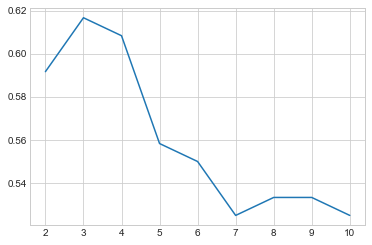

In [15]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
cross_validation_list = np.arange(2,11)
results = list()
for cv in cross_validation_list:
    result = compute_MLP_with_Classification(testX_data=X_train,testY_data=Y_train,
                                             scaler=StandardScaler(),
                                             cross_validation = cv)  
    result.append(cv)
    results.append(result)
statistical_cols.append('folds')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

### 5th Experiment -  Running the MLP function with default parameters and Leave One Group Out cross validation

In [16]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
results = list()
cv = LeaveOneGroupOut()
splited = cv.split(X_train,default_data_scenario_groups,groups=default_data_scenario_groups)
loo = compute_MLP_with_Classification(testX_data=X_train,testY_data=Y_train,
                                      scaler=StandardScaler(),
                                      cross_validation = splited)  
results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

mae  mse  rmse  precision  accuracy  f1-score
0  1.0  1.0   1.0        0.0       0.0       0.0

### 6th Experiment - Compare cross validation methods

mae       mse      rmse  precision  accuracy  f1-score  \
1  0.453704  0.453704  0.673575   0.477566  0.546296  0.487005   
2  0.525000  0.525000  0.724569   0.442796  0.475000  0.425661   
0  1.000000  1.000000  1.000000   0.000000  0.000000  0.000000   

              method  
1            HoldOut  
2  Stratified K-Fold  
0                LOO

Selected cross validation method:  HoldOut


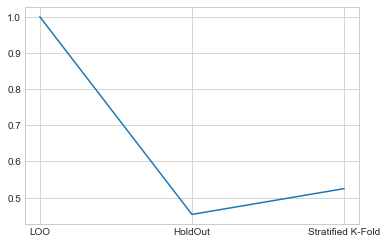

In [17]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','method']
results = list()
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train,Y_train, test_size = size, random_state = 6,stratify=default_data_scenario_groups)
X_train_split = X_train_split.reset_index(drop=True)
X_test_split = X_test_split.reset_index(drop=True)
y_train_split = y_train_split.reset_index(drop=True)
y_test_split = y_test_split.reset_index(drop=True)
holdout = compute_MLP_with_Classification(trainX_data=X_train_split,trainY_data=y_train_split,
                                          testX_data=X_test_split,testY_data=y_test_split,
                                          scaler=StandardScaler())
loo.append('LOO')
results.append(loo)
holdout.append('HoldOut')
results.append(holdout)
skfold = compute_MLP_with_Classification(testX_data=X_train,testY_data=Y_train,
                                         scaler=StandardScaler(),
                                         cross_validation = selected_fold)
skfold.append('Stratified K-Fold')
results.append(skfold)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['method'],statistics['mae'])
selected_method = statistics.sort_values(by=['mae'])['method'].head(1).values[0]
print("Selected cross validation method: ",selected_method)

### 7th Experiment - Running the MLP function with the different activation functions

mae       mse      rmse  precision  accuracy  f1-score  \
2  0.453704  0.453704  0.673575   0.477566  0.546296  0.487005   
1  0.490741  0.490741  0.700529   0.514901  0.509259  0.498277   
0  0.750000  0.750000  0.866025   0.089286  0.250000  0.121429   

  activation_function  
2                relu  
1                tanh  
0            logistic

Selected Activation Function:  relu


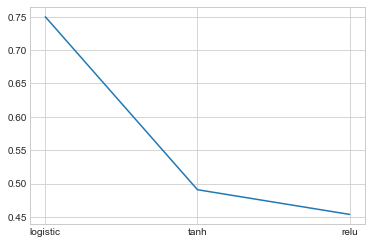

In [18]:
statistical_cols =['mae','mse','rmse','precision','accuracy','f1-score','activation_function']
results = list()
for function in activation_function_list:
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_MLP_with_Classification(testX_data=X_train,testY_data=Y_train,
                                                 scaler=StandardScaler(),
                                                 cross_validation = splited,
                                                 activation_function=function)                                           
    elif selected_method =='Stratified K-Fold':
        result = compute_MLP_with_Classification(testX_data=X_train,testY_data=Y_train,
                                                 scaler=StandardScaler(),
                                                 cross_validation = selected_fold,
                                                 activation_function= function) 
    else:
        result = compute_MLP_with_Classification(trainX_data=X_train_split,trainY_data=y_train_split,
                                                 testX_data=X_test_split,testY_data=y_test_split,
                                                 scaler=StandardScaler(),
                                                 activation_function=function) 
    result.append(function)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['activation_function'],statistics['mae'])
selected_activation_function= statistics.sort_values(by=['mae'])['activation_function'].head(1).values[0]
print("Selected Activation Function: ",selected_activation_function)

### 8th Experiment - Running the MLP function with the different preprocessing methods

mae       mse      rmse  precision  accuracy  f1-score  \
0  0.453704  0.453704  0.673575   0.477566  0.546296  0.487005   
1  0.601852  0.601852  0.775791   0.311596  0.398148  0.347106   
2  0.750000  0.750000  0.866025   0.089286  0.250000  0.121429   
3  0.750000  0.750000  0.866025   0.100722  0.250000  0.135468   

    preprocessing                                  preprocessingFunc  
0  StandardScaler  StandardScaler(copy=True, with_mean=True, with...  
1    MinMaxScaler      MinMaxScaler(copy=True, feature_range=(0, 1))  
2    MaxAbsScaler                            MaxAbsScaler(copy=True)  
3            None                                               None

Selected Preprocessing:  StandardScaler


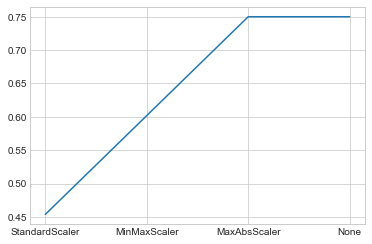

In [19]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','preprocessing','preprocessingFunc']
results = list()
for preprocess in scaler_list:
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_MLP_with_Classification(testX_data=X_train,testY_data=Y_train,
                                                 scaler=preprocess,
                                                 cross_validation = splited)  
    elif selected_method =='Stratified K-Fold':
        result = compute_MLP_with_Classification(testX_data=X_train,testY_data=Y_train,
                                                 scaler=preprocess,
                                                 cross_validation = selected_fold)
    else:
        result = compute_MLP_with_Classification(trainX_data=X_train_split,trainY_data=y_train_split,
                                                 testX_data=X_test_split,testY_data=y_test_split,
                                                 scaler=preprocess)
    if(preprocess is None):
        regex = 'None'
    else:
        regex = re.search('(\w+)\(',str(preprocess)).group(1)
    result.append(regex)
    result.append(preprocess)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['preprocessing'],statistics['mae'])
selected_preprocessing = statistics.sort_values(by=['mae'])['preprocessing'].head(1).values[0]
selected_preprocesssing_func = statistics.sort_values(by=['mae'])['preprocessingFunc'].head(1).values[0]
print("Selected Preprocessing: ",selected_preprocessing)

### 9th Experiment - Running the MLP function with the different solvers

mae       mse      rmse  precision  accuracy  f1-score solvers
2  0.453704  0.453704  0.673575   0.477566  0.546296  0.487005    adam
1  0.462963  0.462963  0.680414   0.534250  0.537037  0.515382     sgd
0  0.564815  0.564815  0.751542   0.468841  0.435185  0.396573   lbfgs

Selected Solver:  adam


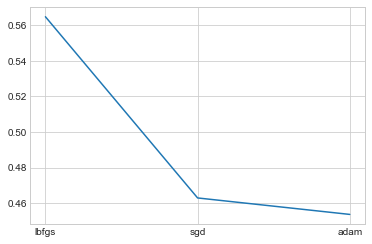

In [20]:
statistical_cols =['mae','mse','rmse','precision','accuracy','f1-score','solvers']
results = list()
for solver in solver_list:
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_MLP_with_Classification(testX_data=X_train,testY_data=Y_train,
                                                 scaler=StandardScaler(),
                                                 cross_validation = splited,
                                                 solver_function=solver)                                           
    elif selected_method =='Stratified K-Fold':
        result = compute_MLP_with_Classification(testX_data=X_train,testY_data=Y_train,
                                                 scaler=StandardScaler(),
                                                 cross_validation = selected_fold,
                                                 solver_function=solver) 
    else:
        result = compute_MLP_with_Classification(trainX_data=X_train_split,trainY_data=y_train_split,
                                                 testX_data=X_test_split,testY_data=y_test_split,
                                                 scaler=StandardScaler(),
                                                 solver_function=solver) 
    result.append(solver)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['solvers'],statistics['mae'])
selected_solver= statistics.sort_values(by=['mae'])['solvers'].head(1).values[0]
print("Selected Solver: ",selected_solver)

### 10th Experiment - Running the MLP function with the different learning rate metrics

mae       mse      rmse  precision  accuracy  f1-score learning_rates
0  0.462963  0.462963  0.680414   0.534250  0.537037  0.515382       constant
2  0.462963  0.462963  0.680414   0.534250  0.537037  0.515382       adaptive
1  0.750000  0.750000  0.866025   0.089286  0.250000  0.121429     invscaling

Selected Learning Rate:  constant


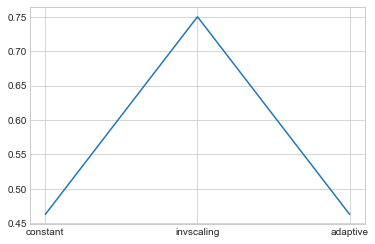

In [21]:
statistical_cols =['mae','mse','rmse','precision','accuracy','f1-score','learning_rates']
results = list()
for rate in learning_rate_list:
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_MLP_with_Classification(testX_data=X_train,testY_data=Y_train,
                                                 scaler=StandardScaler(),
                                                 cross_validation = splited,
                                                 solver_function='sgd',
                                                 learning_rate_value=rate)                                           
    elif selected_method =='Stratified K-Fold':
        result = compute_MLP_with_Classification(testX_data=X_train,testY_data=Y_train,
                                                 scaler=StandardScaler(),
                                                 cross_validation = selected_fold,
                                                 solver_function='sgd',
                                                 learning_rate_value=rate) 
    else:
        result = compute_MLP_with_Classification(trainX_data=X_train_split,trainY_data=y_train_split,
                                                 testX_data=X_test_split,testY_data=y_test_split,
                                                 scaler=StandardScaler(),
                                                 solver_function='sgd',
                                                 learning_rate_value=rate) 
    result.append(rate)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['learning_rates'],statistics['mae'])
selected_learning_rate= statistics.sort_values(by=['mae'])['learning_rates'].head(1).values[0]
print("Selected Learning Rate: ",selected_learning_rate)

### 11th Experiment:  Running the MLP function with the different momentum metrics

mae       mse      rmse  precision  accuracy  f1-score  momentum
1  0.462963  0.462963  0.680414   0.534250  0.537037  0.515382       0.9
0  0.750000  0.750000  0.866025   0.089286  0.250000  0.121429       0.0

Selected Momentum:  0.9


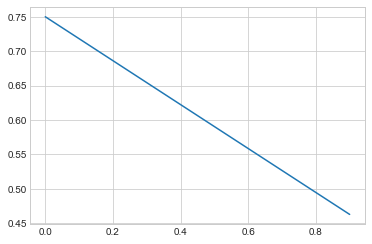

In [22]:
statistical_cols =['mae','mse','rmse','precision','accuracy','f1-score','momentum']
results = list()
for momentum in momentum_list:
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_MLP_with_Classification(testX_data=X_train,testY_data=Y_train,
                                                 scaler=StandardScaler(),
                                                 cross_validation = splited,
                                                 solver_function='sgd',
                                                 momentum_value=momentum)                                           
    elif selected_method =='Stratified K-Fold':
        result = compute_MLP_with_Classification(testX_data=X_train,testY_data=Y_train,
                                                 scaler=StandardScaler(),
                                                 cross_validation = selected_fold,
                                                 solver_function='sgd',
                                                 momentum_value=momentum) 
    else:
        result = compute_MLP_with_Classification(trainX_data=X_train_split,trainY_data=y_train_split,
                                                 testX_data=X_test_split,testY_data=y_test_split,
                                                 scaler=StandardScaler(),
                                                 solver_function='sgd',
                                                 momentum_value=momentum) 
    result.append(momentum)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['momentum'],statistics['mae'])
selected_momentum= statistics.sort_values(by=['mae'])['momentum'].head(1).values[0]
print("Selected Momentum: ",selected_momentum)

### 12th Experiment:  Running the MLP function with the different alpha value metrics

mae       mse      rmse  precision  accuracy  f1-score    alpha
0  0.453704  0.453704  0.673575   0.477566  0.546296  0.487005  0.00010
1  0.453704  0.453704  0.673575   0.477566  0.546296  0.487005  0.00100
2  0.453704  0.453704  0.673575   0.477566  0.546296  0.487005  0.00001
3  0.453704  0.453704  0.673575   0.469241  0.546296  0.484779  0.10000

Selected Alpha:  0.0001


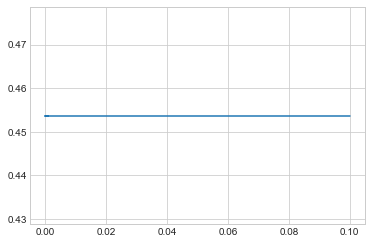

In [23]:
statistical_cols =['mae','mse','rmse','precision','accuracy','f1-score','alpha']
results = list()
for alpha in alpha_list:
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_MLP_with_Classification(testX_data=X_train,testY_data=Y_train,
                                                 scaler=StandardScaler(),
                                                 cross_validation = splited,
                                                 alpha_value=alpha)                                           
    elif selected_method =='Stratified K-Fold':
        result = compute_MLP_with_Classification(testX_data=X_train,testY_data=Y_train,
                                                 scaler=StandardScaler(),
                                                 cross_validation = selected_fold,
                                                 alpha_value=alpha) 
    else:
        result = compute_MLP_with_Classification(trainX_data=X_train_split,trainY_data=y_train_split,
                                                 testX_data=X_test_split,testY_data=y_test_split,
                                                 scaler=StandardScaler(),
                                                 alpha_value=alpha) 
    result.append(alpha)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['alpha'],statistics['mae'])
selected_alpha= statistics.sort_values(by=['mae'])['alpha'].head(1).values[0]
print("Selected Alpha: ",selected_alpha)

### 13th Experiment:  Running the MLP function with the different iteration metrics

mae       mse      rmse  precision  accuracy  f1-score  max_iter
3  0.453704  0.453704  0.673575   0.477566  0.546296  0.487005      1000
4  0.462963  0.462963  0.680414   0.609784  0.537037  0.509886      2000
1  0.601852  0.601852  0.775791   0.294387  0.398148  0.306408       400
2  0.675926  0.675926  0.822147   0.217175  0.324074  0.247585       500
0  0.750000  0.750000  0.866025   0.089286  0.250000  0.121429       200

Selected Maximum iterations:  1000


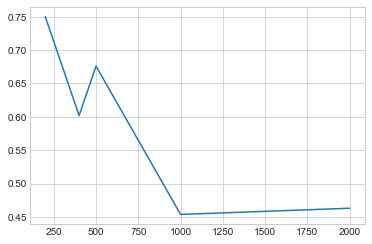

In [25]:
statistical_cols =['mae','mse','rmse','precision','accuracy','f1-score','max_iter']
results = list()
for iteration in number_iterations_list:
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_MLP_with_Classification(testX_data=X_train,testY_data=Y_train,
                                                 scaler=StandardScaler(),
                                                 cross_validation = splited,
                                                 max_iterations=iteration)                                           
    elif selected_method =='Stratified K-Fold':
        result = compute_MLP_with_Classification(testX_data=X_train,testY_data=Y_train,
                                                 scaler=StandardScaler(),
                                                 cross_validation = selected_fold,
                                                 max_iterations=iteration) 
    else:
        result = compute_MLP_with_Classification(trainX_data=X_train_split,trainY_data=y_train_split,
                                                 testX_data=X_test_split,testY_data=y_test_split,
                                                 scaler=StandardScaler(),
                                                 max_iterations=iteration) 
    result.append(iteration)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['max_iter'],statistics['mae'])
selected_max_iterartions= statistics.sort_values(by=['mae'])['max_iter'].head(1).values[0]
print("Selected Maximum iterations: ",selected_max_iterartions)

### 14th Experiment: Running the KNN function with data filtered 

In [26]:
def apply_filter():
    statistical_cols =  ['mae','mse','rmse','precision','accuracy','f1-score','filter']
    results = list()
    for filterelement in filters_list:
        if filterelement == 'Median':
            result = apply_median_filter()
        elif filterelement == 'Mean':
            result = apply_mean_filter()
        else:
            result = compute_MLP_with_Classification(trainX_data=X_train,trainY_data=Y_train,
                                                 testX_data=X_train,testY_data=Y_train,
                                                 scaler=selected_preprocesssing_func,
                                                 cross_validation = selected_fold,
                                                 activation_function=selected_activation_function,
                                                 solver_function=selected_solver,
                                                 learning_rate_value=selected_learning_rate,
                                                 momentum_value=selected_momentum,
                                                 alpha_value=selected_alpha,
                                                 max_iterations=selected_max_iterartions)
            result.append('No Filter')
        results.append(result)
    statistics = pd.DataFrame(columns=statistical_cols,data=results)
    display(statistics.sort_values(by=['mae']))
    plt.plot(statistics['filter'],statistics['mae'])
    selected_filter = statistics.sort_values(by=['mae'])['filter'].head(1).values[0]
    print("Selected Filter: ",selected_filter)
    return selected_filter
            

def apply_median_filter():
    medians = list()
    aps = ['zone']
    for col in X_train.columns: 
         aps.append(col)
    for rp, access_points in reference_points:
        zone = rp
        medians_list = [rp]
        for ap in X_train:
            median = access_points[ap].median()
            medians_list.append(median)
        medians.append(medians_list)
    median_pd = pd.DataFrame(medians,columns = aps)
    x_train = median_pd.iloc[:,1:]
    y_train = median_pd.iloc[:,0:1]
    nan_filler = x_train.min().min()*1.010
    x_train = x_train.replace(0, np.nan)
    x_train = x_train.fillna(nan_filler)
    result = compute_MLP_with_Classification(trainX_data=X_train,trainY_data=Y_train,
                                                 testX_data=X_train,testY_data=Y_train,
                                                 scaler=selected_preprocesssing_func,
                                                 activation_function=selected_activation_function,
                                                 solver_function=selected_solver,
                                                 learning_rate_value=selected_learning_rate,
                                                 momentum_value=selected_momentum,
                                                 alpha_value=selected_alpha,
                                                 max_iterations=selected_max_iterartions)
    result.append('Median')
    return result

def apply_mean_filter(): 
    means = list()
    aps = ['zone']
    for col in X_train.columns: 
         aps.append(col)
    for rp, access_points in reference_points:
        zone = rp
        means_list = [zone]
        for ap in X_train:
            mean = access_points[ap].mean()
            means_list.append(mean)
        means.append(means_list)
    mean_pd = pd.DataFrame(means,columns = aps)
    x_train = mean_pd.iloc[:,1:]
    y_train = mean_pd.iloc[:,0:1]
    nan_filler = x_train.min().min()*1.010
    x_train = x_train.replace(0, np.nan)
    x_train = x_train.fillna(nan_filler)
    result = compute_MLP_with_Classification(trainX_data=X_train,trainY_data=Y_train,
                                                 testX_data=X_train,testY_data=Y_train,
                                                 scaler=selected_preprocesssing_func,
                                                 activation_function=selected_activation_function,
                                                 solver_function=selected_solver,
                                                 learning_rate_value=selected_learning_rate,
                                                 momentum_value=selected_momentum,
                                                 alpha_value=selected_alpha,
                                                 max_iterations=selected_max_iterartions)
    result.append('Mean')
    return result

mae       mse      rmse  precision  accuracy  f1-score     filter
0  0.458333  0.458333  0.677003   0.581298  0.541667  0.503843     Median
1  0.458333  0.458333  0.677003   0.581298  0.541667  0.503843       Mean
2  0.525000  0.525000  0.724569   0.442796  0.475000  0.425661  No Filter

Selected Filter:  Median


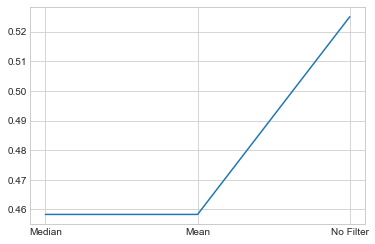

In [27]:
selected_filter = apply_filter()

# Results Analysis and Conclusion
Analysis of the outcomes of the different experiments and final conclusions.

In [28]:
conclusion_cols=['Activation Function','Cross Validation','Solver','Preprocessing','Alpha','Learning Rate','Momentum','Iterations','Filtering']
conclusion_list = [selected_activation_function,selected_method,selected_solver,selected_preprocessing,selected_alpha,
                   selected_learning_rate,selected_momentum,selected_max_iterartions,selected_filter]
conclusion_pd = pd.DataFrame([conclusion_list],columns= conclusion_cols)
display(conclusion_pd)
statistical_cols_csv = conclusion_cols
statistical_cols_csv.append('Experimentation')
result_csv = conclusion_list
result_csv.append('KNN Classifier Bluetooth')
results_csv = [result_csv]
results_df = pd.DataFrame(columns=statistical_cols_csv,data=results_csv)
results_df.to_csv('parameters_neural_networks_results.csv',mode='a',index=False)

Activation Function Cross Validation Solver   Preprocessing   Alpha  \
0                relu          HoldOut   adam  StandardScaler  0.0001   

  Learning Rate  Momentum  Iterations Filtering  
0      constant       0.9        1000    Median

### Best Result

In [29]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
if selected_method == 'LOO':
    cv = LeaveOneGroupOut()
    splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
    result = compute_MLP_with_Classification(trainX_data=X_train,trainY_data=Y_train,
                                                 testX_data=X_train,testY_data=Y_train,
                                                 scaler=selected_preprocesssing_func,
                                                 cross_validation = splited,
                                                 activation_function=selected_activation_function,
                                                 solver_function=selected_solver,
                                                 learning_rate_value=selected_learning_rate,
                                                 momentum_value=selected_momentum,
                                                 alpha_value=selected_alpha,
                                                 max_iterations=selected_max_iterartions)
elif selected_method =='Stratified K-Fold':
    result = compute_MLP_with_Classification(trainX_data=X_train,trainY_data=Y_train,
                                                 testX_data=X_train,testY_data=Y_train,
                                                 scaler=selected_preprocesssing_func,
                                                 cross_validation = selected_fold,
                                                 activation_function=selected_activation_function,
                                                 solver_function=selected_solver,
                                                 learning_rate_value=selected_learning_rate,
                                                 momentum_value=selected_momentum,
                                                 alpha_value=selected_alpha,
                                                 max_iterations=selected_max_iterartions) 
else:
    result = compute_MLP_with_Classification(trainX_data=X_train_split,trainY_data=y_train_split,
                                                 testX_data=X_test_split,testY_data=y_test_split,
                                                 scaler=selected_preprocesssing_func,
                                                 activation_function=selected_activation_function,
                                                 solver_function=selected_solver,
                                                 learning_rate_value=selected_learning_rate,
                                                 momentum_value=selected_momentum,
                                                 alpha_value=selected_alpha,
                                                 max_iterations=selected_max_iterartions)
results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
statistical_cols_csv = ['mae','mse','rmse']
statistical_cols_csv.append('Experimentation')
result_csv = result[0:3]
result_csv.append('MLP Classifier Bluetooth')
results_csv = [result_csv]
results_df = pd.DataFrame(columns=statistical_cols_csv,data=results_csv)
results_df.to_csv('tests_results.csv',mode='a',index=False,header=False)

mae       mse      rmse  precision  accuracy  f1-score
0  0.453704  0.453704  0.673575   0.477566  0.546296  0.487005